In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import Sequential
from keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, Activation, Dropout, Flatten, Input
import tensorflow as tf
from tensorflow.keras import backend as K
tf.random.set_seed(3)
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# import tensorflow.compat.v1.keras.backend as K 
# tf.compat.v1.disable_eager_execution()

In [91]:
def load_data(fileIn):
    
    allData = np.loadtxt(fileIn, skiprows=1)
    # all_df = pd.DataFrame(allData)
    # all_df.columns = allLabels
    
    cond = np.where(allData[:, -2] > 0)
    allData = allData[cond]
    # allData[:, -2] = np.log10(allData[:, -2])

    X = allData[:, :4]
    y = allData[:, 4:]
    return X, y

input_names = ['rx', 'ry', 'rz', 'dist']

In [62]:
num_epochs = 1000
batch_size = 64 #256
learning_rate = 1e-2 #1e-4
decay_rate = 0.0

mode = 'train'

In [63]:


# load the dataset
fileIn = '../data/DOE1.out'
X, y = load_data(fileIn)

# encode strings to integer
#scaler = StandardScaler(with_mean=False)
scaler = StandardScaler()
#scaler = MinMaxScaler( feature_range=(y.min(), y.max()) )
y = scaler.fit_transform(y)

# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# determine the number of input features
n_features = X_train.shape[1]
print(n_features)

(404, 4) (45, 4) (404, 2) (45, 2)
4


In [64]:
p_dropout = 0.01
# define model

model = Sequential()
model.add(Dense(16, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
# model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
# model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(p_dropout))
model.add(Dense(y.shape[1], activation='linear'))


# inputs = Input(((n_features)))
# x = Dense(16, activation="relu", kernel_initializer='he_normal')(inputs)
# x = Dense(32, activation="relu", kernel_initializer='he_normal')(x)
# x = Dense(128, activation="relu", kernel_initializer='he_normal')(x)
# x = Dropout(p_dropout)(x)
# predictions = Dense(y.shape[1], activation='linear')(x)
# model = Model(inputs=inputs, outputs=predictions)

In [65]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
K.set_value(model.optimizer.lr, learning_rate)
K.set_value(model.optimizer.decay, decay_rate)
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 16)                80        
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_33 (Dense)            (None, 2)                 34        
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________


2/2 [==============================] - 0s 2ms/step - loss: 0.1549 - mean_squared_error: 0.1549
Test Accuracy: 0.155
INFO:tensorflow:Assets written to: ../model/mlp43/assets


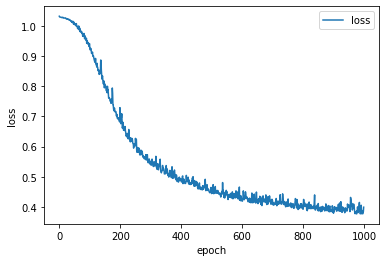

In [66]:

if mode == 'train': 
    # fit the model
    train_history = model.fit(X_train, y_train, epochs= num_epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    print('Test Accuracy: %.3f' % acc)
    # save the model
    tf.keras.models.save_model(model, '../model/mlp43', overwrite=True, include_optimizer=True, save_format=None, signatures=None, options=None)

    
if mode == 'train':
    plt.figure(2111)
    plt.plot(train_history.history['loss'], label = 'loss')
    # plt.plot(train_history.history['val_loss'], label = 'val loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [67]:
########################
########################
# load a trained model
model = tf.keras.models.load_model('../model/mlp43')

# make a prediction
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

########################


In [68]:
y_pred.shape, y_test.shape

((45, 2), (45, 2))

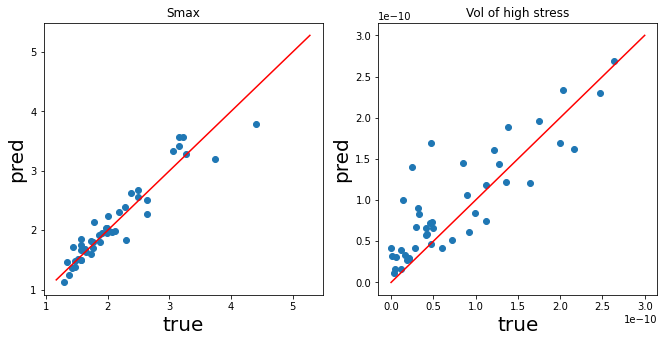

In [69]:
f, a = plt.subplots(1, 2, figsize=(11, 5))
allLabels = ['rx', 'ry', 'rz', 'dist', 'Smax', 'Vol of high stress']

a[0].scatter(y_test[:, 0], y_pred[:, 0])
a[0].title.set_text(allLabels[4])
# a[0].set_xlim(0.2*np.min(y_test[:, 0]), 1.5*np.max(y_test[:, 0]))
# a[0].set_ylim(0.2*np.min(y_test[:, 0]), 1.5*np.max(y_pred[:, 0]))
a[0].set_xlabel('true', fontsize=20)
a[0].set_ylabel('pred', fontsize=20)
a[0].plot([0.9*np.min(y_test[:, 0]), 1.2*np.max(y_test[:, 0])], [0.9*np.min(y_test[:, 0]), 1.2*np.max(y_test[:, 0])], 'r')


a[1].scatter(y_test[:, 1], y_pred[:, 1])
a[1].title.set_text(allLabels[5])
# a[1].set_xlim(0.2*np.min(y_test[:, 1]), 1.5*np.max(y_test[:, 1]))
# a[1].set_ylim(0.2*np.min(y_test[:, 1]), 1.5*np.max(y_pred[:, 1]))
a[1].set_xlabel('true', fontsize=20)
a[1].set_ylabel('pred', fontsize=20)
a[1].plot([0,3e-10], [0,3e-10], 'r')

plt.savefig('../plots/mlp')
plt.show()

In [70]:
from tensorflow.python.keras.backend import eager_learning_phase_scope
from tensorflow.keras import backend as K

mc_samples = 100
f = K.function([model.layers[0].input], [model.output])
    
# Run the function for the number of mc_samples with learning_phase enabled
with eager_learning_phase_scope(value=1): # 0=test, 1=train
    Yt_hat = np.array([f((X_test))[0] for _ in range(mc_samples)])
    
y_mean = np.mean(Yt_hat, axis=0)
y_std = np.std(Yt_hat, axis=0)

y_mean = scaler.inverse_transform(y_mean)
y_std = scaler.inverse_transform(y_std)

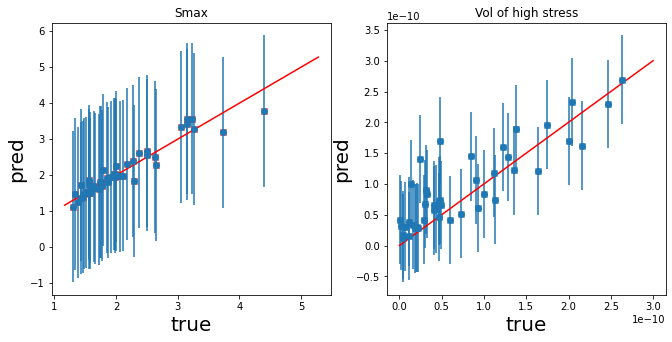

In [71]:
f, a = plt.subplots(1, 2, figsize=(11, 5))
allLabels = ['rx', 'ry', 'rz', 'dist', 'Smax', 'Vol of high stress']

a[0].errorbar(y_test[:, 0], y_mean[:, 0], yerr = y_std[:, 0], fmt="o")
a[0].scatter(y_test[:, 0], y_pred[:, 0], marker='x', color='r')
a[0].title.set_text(allLabels[4])
# a[0].set_xlim(0.2*np.min(y_test[:, 0]), 1.5*np.max(y_test[:, 0]))
# a[0].set_ylim(0.2*np.min(y_test[:, 0]), 1.5*np.max(y_pred[:, 0]))
a[0].set_xlabel('true', fontsize=20)
a[0].set_ylabel('pred', fontsize=20)
a[0].plot([0.9*np.min(y_test[:, 0]), 1.2*np.max(y_test[:, 0])], [0.9*np.min(y_test[:, 0]), 1.2*np.max(y_test[:, 0])], 'r')


a[1].errorbar(y_test[:, 1], y_mean[:, 1], yerr = y_std[:, 1], fmt="o")
a[1].scatter(y_test[:, 1], y_pred[:, 1], marker='x')
a[1].title.set_text(allLabels[5])
# a[1].set_xlim(0.2*np.min(y_test[:, 1]), 1.5*np.max(y_test[:, 1]))
# a[1].set_ylim(0.2*np.min(y_test[:, 1]), 1.5*np.max(y_pred[:, 1]))
a[1].set_xlabel('true', fontsize=20)
a[1].set_ylabel('pred', fontsize=20)
a[1].plot([0,3e-10], [0,3e-10], 'r')

plt.savefig('../plots/mlp_drop')
plt.show()

In [72]:
# shap.__version__, tf.__version__

In [73]:
# import shap

In [74]:
# background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
# # shap.explainers.deep.deep_tf.op_handlers["AddV2"] = shap.explainers.deep.deep_tf.passthrough

# explainer = shap.DeepExplainer( (model.layers[0].input, model.layers[-1].output), background )

# shap_values = explainer.shap_values(X_test[:3]) # <-- HERE !

# # print the JS visualization code to the notebook
# shap.initjs()
# # shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=X_train.columns)

In [75]:
# explainer = shap.DeepExplainer( model, background )
# shap_values = explainer.shap_values(X_test[:3])

In [76]:
# X_test.shape

In [77]:
# import shap

# # select a set of background examples to take an expectation over
# background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# # explain predictions of the model on three images
# # e = shap.DeepExplainer(model, background)
# e = shap.DeepExplainer( (model.layers[0].input, model.layers[-1].output), background)
# # ...or pass tensors directly
# # e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
# shap_values = e.shap_values(X_test[1:5])

In [78]:
from alibi.explainers import KernelShap
from alibi.explainers import IntegratedGradients
import shap

predictor = model.predict
# explainer = SomeExplainer(predictor), **kwargs)

dict_keys(['attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target'])
[0.24665283 0.15806159 0.14138033 0.05927886] [0. 0. 0. 0.]


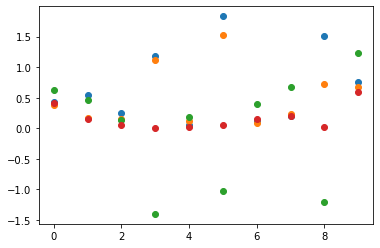

In [92]:
# Initialize IntegratedGradients instance
n_steps = 50
method = "gausslegendre"
ig  = IntegratedGradients(model, n_steps=n_steps, method=method)

# Calculate attributions for the first 10 images in the test set
nb_samples = 10
X_test_sample = X_test[:nb_samples]
predictions = model(X_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(X_test_sample, baselines=None, target=predictions)

# Metadata from the explanation object
explanation.meta

# Data fields from the explanation object
print(explanation.data.keys())

# Get attributions values from the explanation object
attrs = explanation.attributions[0]
      
plt.plot(attrs, 'o')
      
      
image_id = 2
attr = attrs[image_id]
attr_pos = attr.clip(0, 1)
attr_neg = attr.clip(-1, 0)
      
      
print(attr_pos, attr_neg)

In [95]:
ex = shap.KernelExplainer( predictor, X_train, features = input_names)
shap_values = ex.shap_values(X_test[0:nb_samples, :])
# shap.force_plot(ex.expected_value, shap_values[0], X_test[0:10,:])
shap.force_plot(ex.expected_value[0], shap_values[0], feature_names = input_names)

Using 404 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [97]:
shap.force_plot(ex.expected_value[1], shap_values[1], feature_names = input_names)

In [98]:
shap_values[0].shape, X_test.shape

((10, 4), (45, 4))

Using 404 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


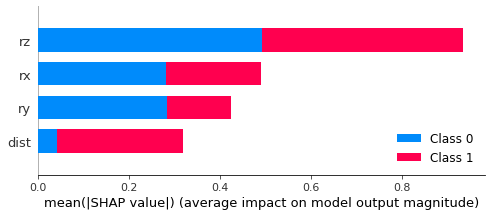

In [105]:
explainer = shap.KernelExplainer(predictor, X_train, features = input_names)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = input_names)

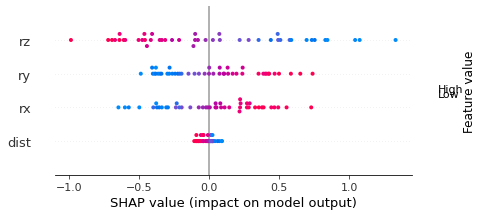

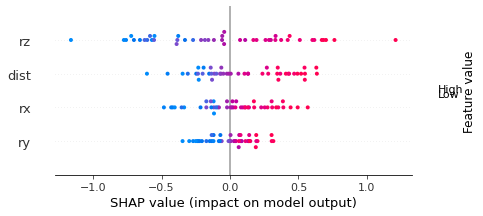

In [106]:
shap.summary_plot(shap_values[0], X_test, feature_names = input_names)
shap.summary_plot(shap_values[1], X_test, feature_names = input_names)

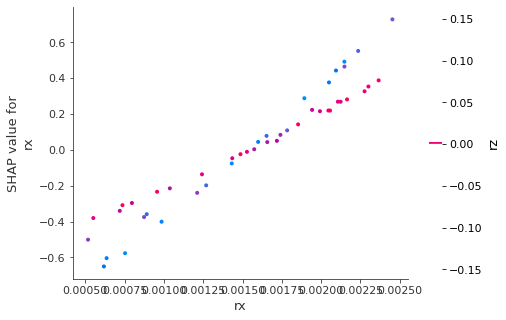

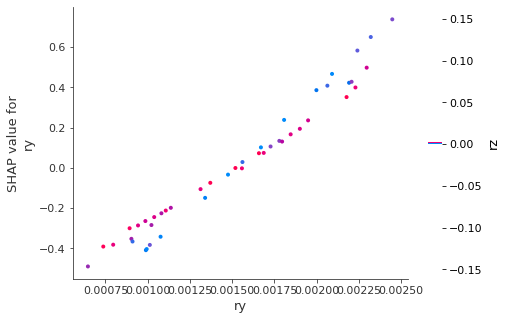

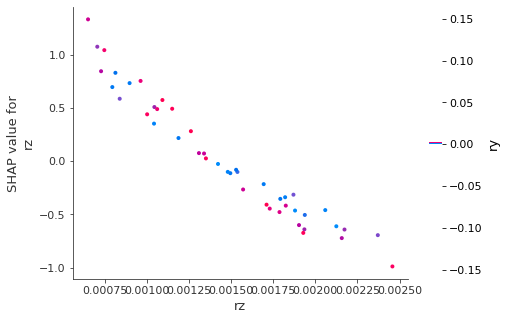

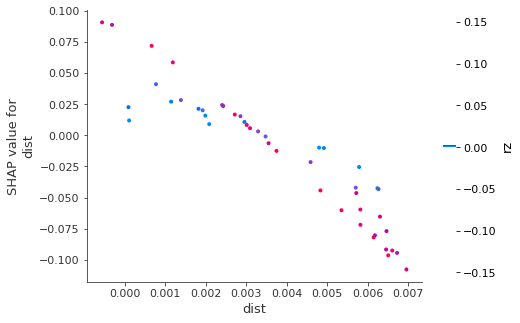

In [109]:
shap.dependence_plot(0, shap_values[0], X_test, feature_names = input_names)
shap.dependence_plot(1, shap_values[0], X_test, feature_names = input_names)
shap.dependence_plot(2, shap_values[0], X_test, feature_names = input_names)
shap.dependence_plot(3, shap_values[0], X_test, feature_names = input_names)

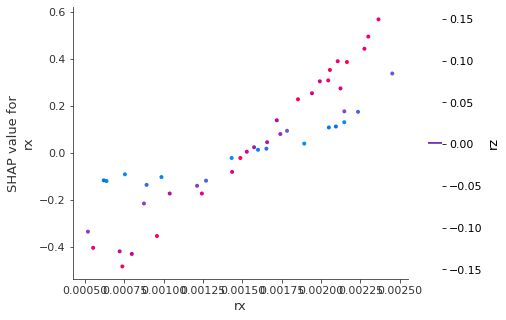

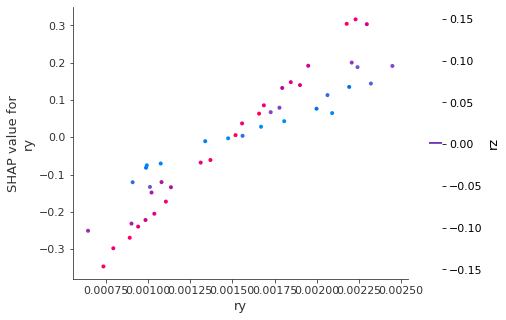

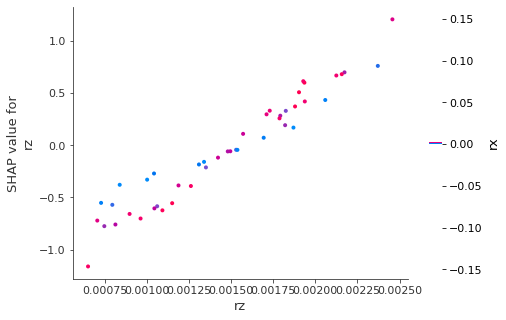

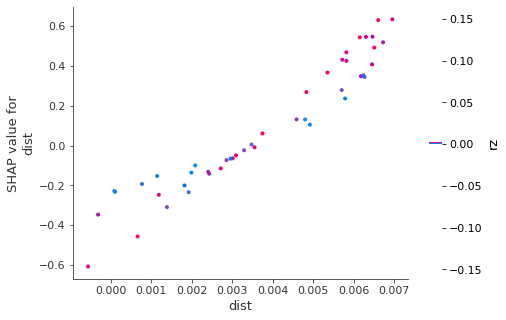

In [110]:
shap.dependence_plot(0, shap_values[1], X_test, feature_names = input_names)
shap.dependence_plot(1, shap_values[1], X_test, feature_names = input_names)
shap.dependence_plot(2, shap_values[1], X_test, feature_names = input_names)
shap.dependence_plot(3, shap_values[1], X_test, feature_names = input_names)

array([[<AxesSubplot:xlabel='0', ylabel='ALE'>,
        <AxesSubplot:xlabel='1', ylabel='ALE'>,
        <AxesSubplot:xlabel='2', ylabel='ALE'>,
        <AxesSubplot:xlabel='3', ylabel='ALE'>]], dtype=object)

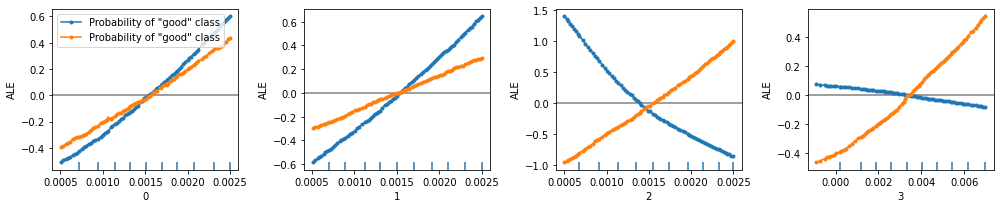

In [112]:
# Global vs local explain
# https://docs.seldon.io/projects/alibi/en/latest/overview/high_level.html#global-feature-attribution
# https://docs.seldon.io/projects/alibi/en/latest/methods/ale_figures.html?highlight=plot_ale#ALE-Figures


from alibi.explainers import ALE
from alibi.explainers import plot_ale

# predict_fn = lambda x: model(scaler.transform(x)).numpy()[:, 0]
predict_fn = predictor

ale = ALE(predict_fn, feature_names=input_names)
exp = ale.explain(X_train)
# plot_ale(exp, features=['rx'], line_kw={'label': 'Probability of "good" class'})
# plot_ale(exp, features=['ry'], line_kw={'label': 'Probability of "good" class'})
# plot_ale(exp, features=['rz'], line_kw={'label': 'Probability of "good" class'})
# plot_ale(exp, features=['dist'], line_kw={'label': 'Probability of "good" class'})

fig, ax = plt.subplots(1, 4, figsize=(14, 3))
plot_ale(exp, features=input_names, line_kw={'label': 'Probability of "good" class'}, ax = ax)

In [118]:
np.array(exp.ale_values).shape, X_train.shape

((4, 81, 2), (404, 4))

In [121]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# plot_ale(exp, features=[0], ax=ax[0]);
# plot_ale(exp, features=[1], ax=ax[1]);